# TMM stability against changes in initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
import studenttmixture
import scipy
import tqdm
import sklearn.mixture

# own code
import src.corc.datasets_refactor as datasets2d
import src.corc.jax_neb as jax_neb
import src.corc.tmm_plots as tmm_plots

In [9]:
key = jrandom.PRNGKey(0)
data_X, data_y = datasets2d.Clusterlab10().sample(key=key, n=300)

In [68]:
tmms = list()
for i in tqdm.trange(10, desc='tmm'):
    tmm = studenttmixture.EMStudentMixture(
        n_components=15,
        n_init=5,
        fixed_df=True,
        df=1.0,
        init_type="k++",
        random_state=42+i
    )
    tmm.fit(np.array(data_X, dtype=np.float64))
    tmms.append(tmm)

gmms = list()
for i in tqdm.trange(10, desc='gmm'):
    gmm = sklearn.mixture.GaussianMixture(
        n_components=15,
        n_init=5,
        random_state=42+i,
        init_params='k-means++',
        covariance_type='full',
    )
    gmm.fit(np.array(data_X, dtype=np.float64))
    gmms.append(gmm)

gmm: 100%|██████████| 10/10 [00:00<00:00, 22.79it/s]


In [62]:
gmm = gmms[1]
gmm.weights_

array([0.06529259, 0.01434238, 0.13731974, 0.13579032, 0.05491551,
       0.16666667, 0.03597703, 0.02934693, 0.15232429, 0.04577969,
       0.00666666, 0.05228658, 0.04908751, 0.03087635, 0.02332778])

In [64]:
iterations = 250
adjacencies = list()
raws = list()
all_paths = list()
for i in range(10):
    adjacency, raw_adjacency, paths, _, _ = jax_neb.compute_neb_paths(gmms[i], iterations=iterations)
    adjacencies.append(adjacency)
    raws.append(raw_adjacency)
    all_paths.append(paths)
    

100%|██████████| 105/105 [01:46<00:00,  1.01s/it]


In [65]:
centers = list()
for i in tqdm.trange(10):
    adjacency = adjacencies[i]
    thresholds = np.unique(adjacency)
    thresholds = sorted(thresholds.tolist())
    for threshold in thresholds:
        tmp_adj = np.array(adjacency >= threshold, dtype=int)
        n_components, clusters = scipy.sparse.csgraph.connected_components(tmp_adj)
        
        gt_components = len(np.unique(data_y))# target number of components
        if n_components == gt_components: 
            locations = tmms[i].location
            cluster_means = [np.mean(locations[clusters == i], axis=0) for i in range(gt_components)]
            centers.append(np.array(cluster_means))

100%|██████████| 10/10 [00:00<00:00, 514.05it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

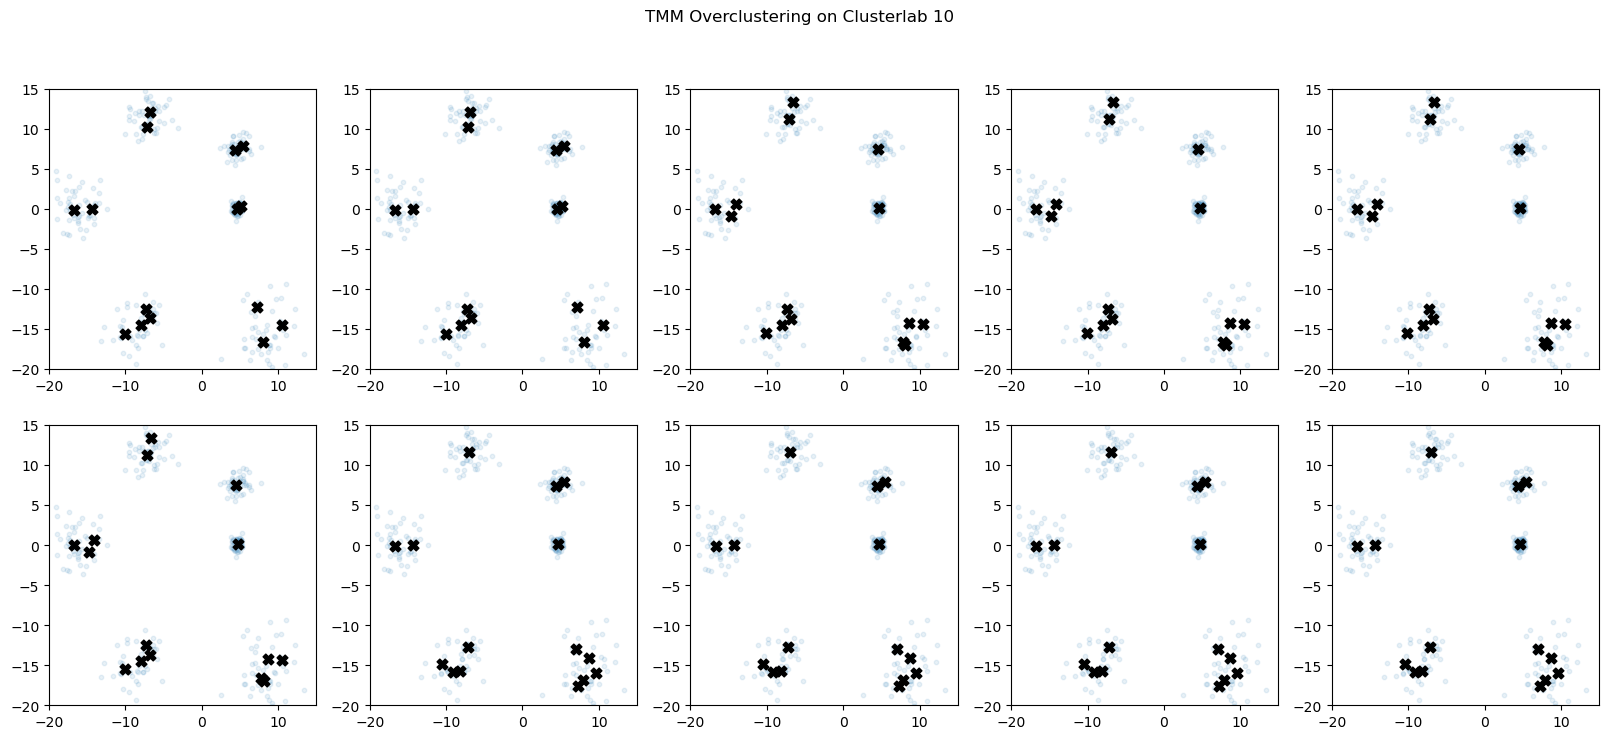

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
fig.suptitle('TMM Overclustering on Clusterlab 10')
for i in range(2):
    for j in range(5):
        axes[i,j].scatter(data_X[:, 0], data_X[:, 1], s=10, label="raw data", alpha=0.1)
        
        axes[i,j].scatter(tmms[5*i+j].location[:, 0], tmms[5*i+j].location[:, 1], color="black", marker="X", s=60)
        axes[i,j].set_xlim(-20,15)
        axes[i,j].set_ylim(-20,15)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

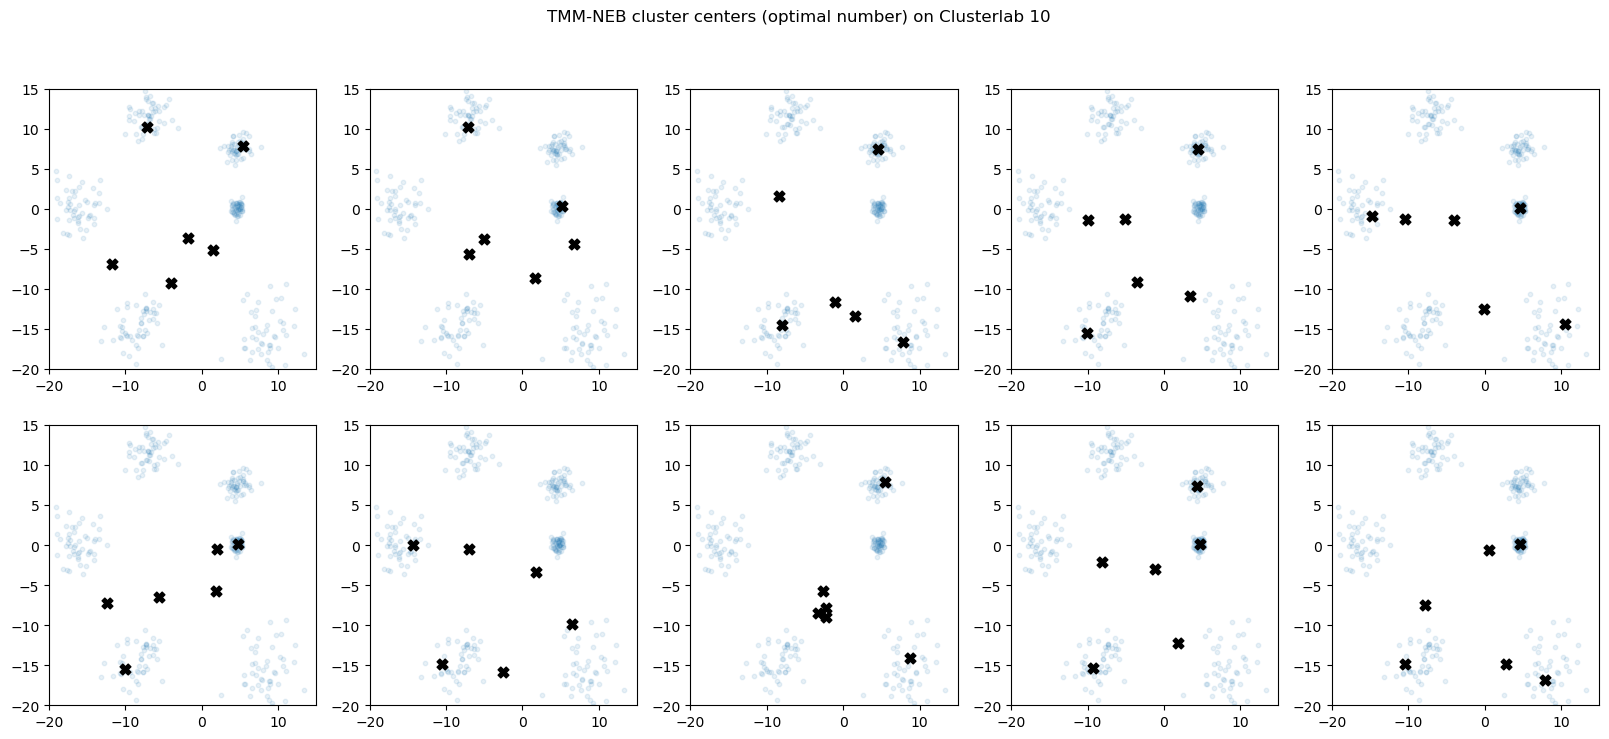

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
fig.suptitle('TMM-NEB cluster centers (optimal number) on Clusterlab 10')
for i in range(2):
    for j in range(5):
        axes[i,j].scatter(data_X[:, 0], data_X[:, 1], s=10, label="raw data", alpha=0.1)

        axes[i,j].scatter(centers[5*i+j][:, 0], centers[5*i+j][:, 1], color="black", marker="X", s=60)
        axes[i,j].set_xlim(-20,15)
        axes[i,j].set_ylim(-20,15)
plt.show

In [33]:
np.array(centers[0])

array([[ -7.01096222,  11.2539782 ],
       [  8.61485164, -15.00359834],
       [  4.90681404,   4.87880544],
       [ -8.2711781 , -14.19646374],
       [-16.70460566,  -0.061068  ],
       [-14.34171291,   0.03211017]])